In [20]:
#loading required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import matplotlib.ticker as ticker
from sklearn.model_selection import GridSearchCV, KFold

This is the FY2023 data for EPA government contract

In [21]:
#loading the data
df = pd.read_csv('data.csv')
df.head()

,parent_award_agency_name,potential_days,awarding_office_name,funding_office_name,foreign_funding_description,recipient_state_name,primary_place_of_performance_state_name,award_or_idv_flag,type_of_contract_pricing,product_or_service_code_description,...,historically_black_college,tribal_college,alaskan_native_servicing_institution,native_hawaiian_servicing_institution,school_of_forestry,veterinary_college,dot_certified_disadvantage,self_certified_small_disadvantaged_business,small_disadvantaged_business,y
0,NaN,1119.00,ORD SIMPLIFIED ACQ BRANCH (SAB),OFC RESEARCH DEV (ORD) (FUNDING),NOT APPLICABLE,MASSACHUSETTS,OHIO,AWARD,FIRM FIXED PRICE,MAINT/REPAIR/REBUILD OF EQUIPMENT- INSTRUMENTS...,...,f,f,f,f,f,f,f,f,f,69560.96
1,NaN,1119.00,ORD SIMPLIFIED ACQ BRANCH (SAB),OFC RESEARCH DEV (ORD) (FUNDING),NOT APPLICABLE,MASSACHUSETTS,OHIO,AWARD,FIRM FIXED PRICE,MAINT/REPAIR/REBUILD OF EQUIPMENT- INSTRUMENTS...,...,f,f,f,f,f,f,f,f,f,69560.96
2,ENVIRONMENTAL PROTECTION AGENCY,1884.00,HEADQUARTERS ACQUISITION DIV (HQAD),OFC RESEARCH DEV (ORD) (FUNDING),NOT APPLICABLE,VIRGINIA,OHIO,AWARD,FIRM FIXED PRICE,PHOTO/MAP/PRINT/PUBLICATION- ARTS/GRAPHICS,...,f,f,f,f,f,f,f,t,f,556018.35
3,ENVIRONMENTAL PROTECTION AGENCY,1976.00,HEADQUARTERS ACQUISITION DIV (HQAD),OFC RESEARCH DEV (ORD) (FUNDING),NOT APPLICABLE,VIRGINIA,OHIO,AWARD,FIRM FIXED PRICE,PHOTO/MAP/PRINT/PUBLICATION- ARTS/GRAPHICS,...,f,f,f,f,f,f,f,t,f,567243.48
4,ENVIRONMENTAL PROTECTION AGENCY,1915.00,HEADQUARTERS ACQUISITION DIV (HQAD),OFC RESEARCH DEV (ORD) (FUNDING),NOT APPLICABLE,VIRGINIA,OHIO,AWARD,FIRM FIXED PRICE,PHOTO/MAP/PRINT/PUBLICATION- ARTS/GRAPHICS,...,f,f,f,f,f,f,f,t,f,556018.35


# Data Exploration

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12542 entries, 0 to 12541
Data columns (total 80 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   parent_award_agency_name                         10142 non-null  object 
 1   potential_days                                   11880 non-null  float64
 2   awarding_office_name                             12542 non-null  object 
 3   funding_office_name                              12542 non-null  object 
 4   foreign_funding_description                      12542 non-null  object 
 5   recipient_state_name                             12531 non-null  object 
 6   primary_place_of_performance_state_name          11863 non-null  object 
 7   award_or_idv_flag                                12542 non-null  object 
 8   type_of_contract_pricing                         12542 non-null  object 
 9   product_or_service_code_desc

In [24]:
df.columns

Index(['parent_award_agency_name', 'potential_days', 'awarding_office_name',
       'funding_office_name', 'foreign_funding_description',
       'recipient_state_name', 'primary_place_of_performance_state_name',
       'award_or_idv_flag', 'type_of_contract_pricing',
       'product_or_service_code_description', 'naics_description',
       'parent_award_single_or_multiple', 'multi_year_contract',
       'minority_owned_business', 'business_size', 'emerging_small_business',
       'community_developed_corporation_owned_firm', 'labor_surplus_area_firm',
       'us_federal_government',
       'federally_funded_research_and_development_corp', 'federal_agency',
       'us_state_government', 'us_local_government', 'city_local_government',
       'county_local_government', 'inter_municipal_local_government',
       'local_government_owned', 'municipality_local_government',
       'school_district_local_government', 'township_local_government',
       'us_tribal_government', 'foreign_governmen

In [25]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,potential_days,y
count,11880.00,12542.00
mean,1139.92,13821297.01
std,800.03,190957763.74
min,0.00,0.00
25%,395.00,132395.30
50%,1094.00,641401.31
75%,1824.00,3142033.00
max,9131.00,5776500000.00


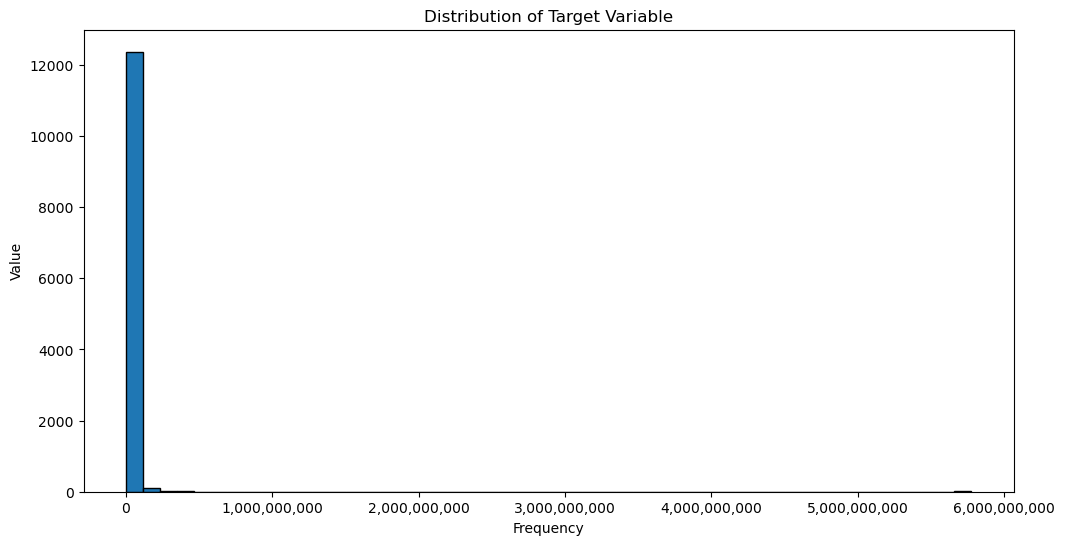

In [26]:
#looking at the distribution of the target variable
plt.figure(figsize=(12, 6))
plt.hist(df.y, bins=50, edgecolor='black')
plt.title('Distribution of Target Variable')
plt.xlabel('Frequency')
plt.ylabel('Value')
# Format y-axis values to display as regular numbers
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

# Data Processing

In [27]:
#remove y outliers with value more than 10000000
df = df[df['y'] < 4000000]

In [28]:
#find the missing values sum
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values

multi_year_contract                        2965
parent_award_single_or_multiple            1669
parent_award_agency_name                   1669
organizational_type                         196
primary_place_of_performance_state_name     165
                                           ... 
township_local_government                     0
school_district_local_government              0
municipality_local_government                 0
local_government_owned                        0
y                                             0
Length: 80, dtype: int64

In [29]:
#encoding the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

#split the data into X and y
X = df.drop('y', axis=1)
y = df['y']

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# Create an XGBoost regressor
xgb_reg = XGBRegressor(n_estimators=200)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'reg_lambda': [0.001, 0.01, 0.1, 1.0, 10.0]  # Specify the range of values for reg_lambda
}

# Define the scoring function
scoring = 'neg_mean_squared_error'

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning with cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Create a feature selection model using the best XGBoost regressor
best_xgb_reg = XGBRegressor(n_estimators=200, **best_params)
feature_selection_model = RFE(best_xgb_reg, n_features_to_select=10, step=1)

# Fit the feature selection model on the training data
feature_selection_model.fit(X_train, y_train)

# Transform the training and testing data based on the selected features
X_train_selected = feature_selection_model.transform(X_train)
X_test_selected = feature_selection_model.transform(X_test)

# Now, you can fit your model on the selected features
# For example, fitting an XGBoost regressor on the selected features
best_xgb_reg.fit(X_train_selected, y_train)

# Use the model to make predictions
predictions = best_xgb_reg.predict(X_test_selected)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Best hyperparameters: {'reg_lambda': 1.0}
Mean Absolute Error (MAE): 396022.42666050524
Mean Squared Error (MSE): 409168904287.0349
Root Mean Squared Error (RMSE): 639663.1178104886
R-squared (R2): 0.6128995827675832


                                       Feature  Importance
9                 small_disadvantaged_business        0.17
7                   dot_certified_disadvantage        0.15
4                          multi_year_contract        0.13
6                                   foundation        0.11
3                            naics_description        0.09
5                                business_size        0.08
0                               potential_days        0.08
1                     type_of_contract_pricing        0.08
2          product_or_service_code_description        0.07
8  self_certified_small_disadvantaged_business        0.06


<Axes: xlabel='Feature'>

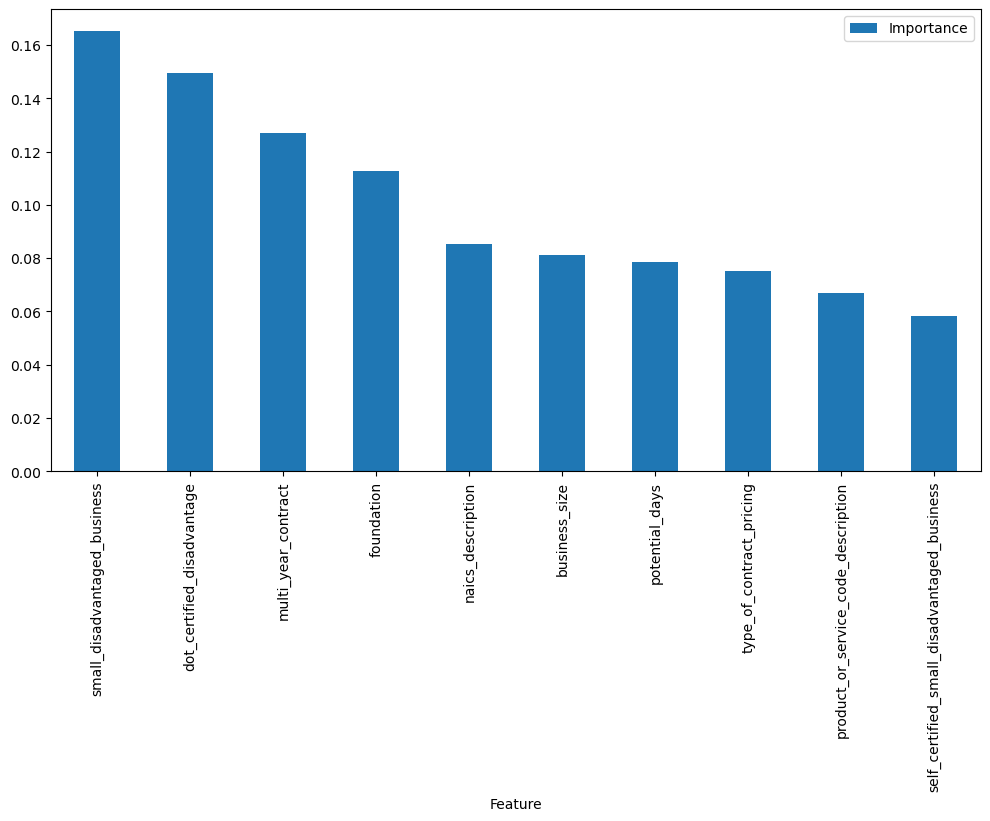

In [32]:
# Get the mask of selected features
selected_features_mask = feature_selection_model.get_support()

# Get the names of the selected features
selected_features = X_train.columns[selected_features_mask]

# Get feature importances
importances = best_xgb_reg.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importances)

#graph of feature importances
feature_importances.plot(x='Feature', y='Importance', kind='bar', figsize=(12, 6))

In [40]:
#create sample dataset to predict
sample = pd.DataFrame({
    'small_disadvantaged_business': 't',
    'dot_certified_disadvantage': 't',
    'multi_year_contract': 't',
    'foundation': 't',
    'naics_description': 'REMEDIATION SERVICES',
    'business_size': 'SMALL BUSINESS',
    'potential_days': 500,
    'type_of_contract_pricing': 'FIRM FIXED PRICE',
    'product_or_service_code_description': 'ENVIRONMENTAL SYSTEMS PROTECTION- ENVIRONMENTAL REMEDIATION',
    'self_certified_small_disadvantaged_business': 't'
}, index=[0])

#encode the sample dataset
categorical_columns = sample.select_dtypes(include=['object']).columns

for column in categorical_columns:
    sample[column] = LabelEncoder().fit_transform(sample[column])

#predict the value
prediction = best_xgb_reg.predict(sample)

print("Predicted value:", prediction[0])



Predicted value: 1514168.1
